In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
from model_generation import generate_model

model = generate_model()

C:\Users\Thomas\Anaconda3\envs\tensorflowgpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [7]:
model3 = generate_model(noise=True)
model4 = generate_model(nums=[0,1],name="keras_mnist_model_zero_onev1.h5")

In [24]:
model5 = generate_model(nums=[0,1,2], name="keras_mnist_model_zero_to_twov1.h5")

In [23]:
model6 = generate_model(nums=[0,1,2,3], name="keras_mnist_model_zero_to_threev1.h5")

In [60]:
model7 = generate_model(nums=[1,7], name="keras_mnist_model_one_sevenv1.h5")

In [61]:
model8 = generate_model(nums=[0,1,7], name="keras_mnist_model_zero_one_sevenv1,h5")

C:\Users\Thomas\Documents\Networks\math276\Thomas\model_generation.py:76: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(1, 28, 28..., activation="relu")`
  model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(1,28,28)))
C:\Users\Thomas\Documents\Networks\math276\Thomas\model_generation.py:77: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  model.add(Convolution2D(32, 3, 3, activation='relu'))
C:\Users\Thomas\Anaconda3\envs\tensorflowgpu\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
18930/18930 [==============================] - 13s 664us/step - loss: 0.0530 - acc: 0.9862
Epoch 2/10
18930/18930 [==============================] - 12s 620us/step - loss: 0.0126 - acc: 0.9961
Epoch 3/10
18930/18930 [==============================] - 11s 604us/step - loss: 0.0099 - acc: 0.9968
Epoch 4/10
18930/18930 [==============================] - 11s 597us/step - loss: 0.0096 - acc: 0.9969
Epoch 5/10
18930/18930 [==============================] - 11s 588us/step - loss: 0.0068 - acc: 0.9977
Epoch 6/10
 8768/18930 [============>.................] - ETA: 6s - loss: 0.0065 - acc: 0.9981

KeyboardInterrupt: 

In [3]:
weights = model.get_weights()
thresh = np.percentile(np.abs(weights[-2]), 20)
weights[-2][np.abs(weights[-2])<thresh] = 0.0
config = model.get_config()
from keras.models import Sequential
model2 = Sequential.from_config(config)
model2.set_weights(weights)
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [4]:
from model_generation import generate_data
X_train, X_test, Y_train, Y_test = generate_data()
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)
score = model2.evaluate(X_test, Y_test, verbose=0)
print(score)

[0.027638991620726572, 0.9917]
[0.026397230025109547, 0.9921]


In [5]:
X_train_noise, X_test_noise, Y_train, Y_test = generate_data(noise=True)
score = model.evaluate(X_test_noise, Y_test, verbose=0)
print(score)
score = model3.evaluate(X_test_noise, Y_test, verbose=0)
print(score)

[0.7950517480492592, 0.8241]
[0.7950517480492592, 0.8241]


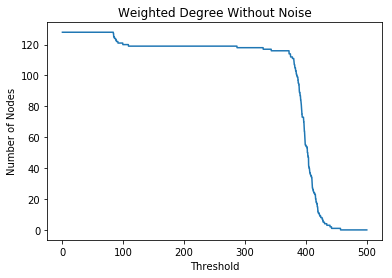

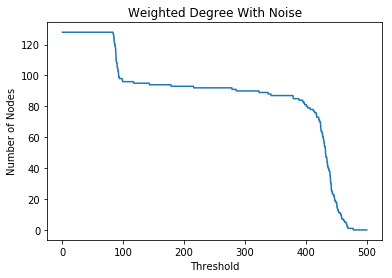

In [4]:
# function counting the number of nodes above a threshold
def thresh_count(arr, thresh):
    return(np.sum(arr > thresh))


def plot_l1_norm(model, title=""):
    # get the dense layer
    dense_layer= model.layers[-3]

    # pull out the weights
    dense_weights = np.array(dense_layer.get_weights())

    # compute the L1 norm for the dense weights
    dense_L1 = np.sum(np.abs(dense_weights[0]), axis = 0)

    # list of thresholds
    thresh_list = np.linspace(0,500, 2000)

    # count the number of nodes for all thresholds
    dense_count = np.array([thresh_count(dense_L1, thresh) for thresh in thresh_list])

    # plot count vs. thresh
    plt.plot(thresh_list, dense_count)
    plt.xlabel("Threshold")
    plt.ylabel("Number of Nodes")
    plt.title(title)
    plt.show()
    
plot_l1_norm(model, title="Weighted Degree Without Noise")
plot_l1_norm(model3, title="Weighted Degree With Noise")

In [55]:
weights = np.abs(np.array(model.layers[-1].get_weights()[0]))
print(weights.shape)
weight_adj_matrix = np.zeros([sum(weights.shape),sum(weights.shape)])
weight_adj_matrix[weights.shape[0]:,:weights.shape[0]] = np.transpose(weights)
print(weight_adj_matrix)

(128, 10)
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.17235444 0.05914584 0.00919179 ... 0.         0.         0.        ]
 [0.39859247 0.14722274 0.36580205 ... 0.         0.         0.        ]
 [0.18943426 0.11194394 0.09362796 ... 0.         0.         0.        ]]


In [9]:
import bct
# bct.betweenness_wei(weight_adj_matrix)

In [56]:
def weighted_clustering_coeff(G):
    """ Calculates clustering coefficient for a weighted network represented by an adjacency matrix """
    # https://www.researchgate.net/publication/49721057_Competition_for_Popularity_in_Bipartite_Networks
    k = G.shape[0] # assume fully connected
    coeffs = np.zeros((k,))
    for i in range(k):
        for j in range(k):
            for h in range(k):
                coeffs[i] += (G[i,j]*G[i,h]*G[h,j])**(1.0/3.0)
        Gv = np.max(G[i,:])
        coeffs[i] *= 2.0/(k*(k-1)*Gv)
    return coeffs

def calc_clustering_coeff_square(weights):
    """ Calculates clustering coefficients for a bipartite weighted network represented by a weight matrix """
    # Compute the unipartite networks correspondign to the bipartite network
    adj1 = np.matmul(weights, np.transpose(weights))
    adj2 = np.matmul(np.transpose(weights), weights)
    return weighted_clustering_coeff(adj1), weighted_clustering_coeff(adj2)

In [57]:
coeffs1, coeffs2 = calc_clustering_coeff_square(weights)

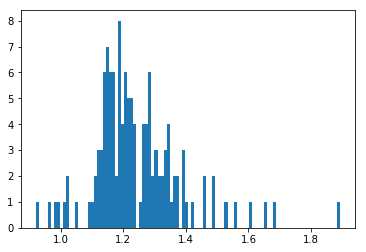

1.2418992631635395


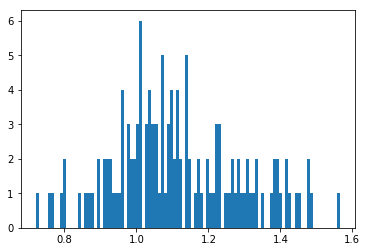

1.1156579708177847


In [59]:
# plt.hist(coeffs1, bins=100, cumulative=True)
plt.hist(coeffs1, bins=100)
plt.show()
print(np.average(coeffs1))

weights_noise = np.abs(np.array(model3.layers[-1].get_weights()[0]))
coeffs1_noise, coeffs2_noise = calc_clustering_coeff_square(weights_noise)
# plt.hist(coeffs1_noise, bins=100, cumulative=True)
plt.hist(coeffs1_noise, bins=100)
plt.show()
print(np.average(coeffs1_noise))

In [101]:
from keras import backend as K

m = model7
nums = [1,7]
n = len(nums)

weights = np.array(m.layers[-1].get_weights()[0])
# Compute the adjacency matrix of the layer
# layer_adj_matrix = np.matmul(weights, np.transpose(weights))

# Permute the weights randomly to prevent indexing bias
perm = np.random.permutation(weights.shape[0])
weights = weights[perm]

weights_norm = np.linalg.norm(weights[:,:], axis=1)
# print(weights_norm)
print(np.diag(np.reciprocal(weights_norm)).shape)
# Normalize weights
weights_normed = np.matmul(np.diag(np.reciprocal(weights_norm)), weights)
layer_adj_matrix = np.matmul(weights_normed[:,:], np.transpose(weights_normed[:,:]))
print(layer_adj_matrix)

# # Compute a layer adjacency matrix composed of 2 nodes repeated 64 times
# print(weights.shape)
# weights_fake = np.concatenate([weights_normed[:16,:]]*8)
# print(weights_fake.shape)
# layer_adj_matrix = np.matmul(weights_fake, np.transpose(weights_fake))

# Find the highest activation image for each node in the first dense layer
from model_generation import generate_data
X_train, X_test, Y_train, Y_test = generate_data(nums=nums)

inp = m.input                                           # input placeholder
outputs = [m.layers[-3].output, m.layers[-1].output]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function

# Testing
test = X_test[:]
# test = X_test_zero_one[:]
layer_outs = functor([test, 1.])
max_vals = np.max(layer_outs[0],axis=0)[perm]
# print(max_vals)
repr_indices = np.argmax(np.abs(layer_outs[0]), axis=0)[perm]
# print(np.argmax(layer_outs[0],axis=1))
print(layer_adj_matrix[max_vals!=0][:,max_vals!=0].shape)

(128, 128)
[[ 1.          0.0773076   0.5499268  ... -0.04955212  0.523412
  -0.2592222 ]
 [ 0.0773076   1.          0.02472727 ...  0.20815444  0.507266
  -0.0239669 ]
 [ 0.5499268   0.02472727  1.         ... -0.7480482   0.61787
  -0.266455  ]
 ...
 [-0.04955212  0.20815444 -0.7480482  ...  1.0000001  -0.2646319
   0.09371626]
 [ 0.523412    0.507266    0.61787    ... -0.2646319   0.99999994
  -0.16426033]
 [-0.2592222  -0.0239669  -0.266455   ...  0.09371626 -0.16426033
   1.0000002 ]]
(106, 106)


In [50]:
# print(layer_outs[1].shape)
print(np.min(weights))
print(np.min(layer_outs[0]))
print(np.sum(weights[:,:2], axis=0))
best_partners = np.argmax(layer_adj_matrix-np.eye(95),axis=0)
labels = np.argmax(Y_test_zero_one,axis=1)[repr_indices]
print(labels)
print(best_partners)
for i in range(len(best_partners)):
    print(labels[i]-labels[best_partners[i]])

-0.609813
0.0
[-10.350499    4.6536293]


ValueError: operands could not be broadcast together with shapes (128,128) (95,95) 

In [102]:
layer_adj_matrix = layer_adj_matrix[max_vals!=0][:,max_vals!=0]
print(np.max(layer_adj_matrix - layer_adj_matrix.transpose()))

0.0


2.2095149159431458


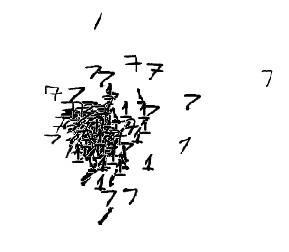

In [103]:
import networkx as nx
from networkx.drawing import spring_layout

# thresh = np.percentile(np.abs(layer_adj_matrix), 10)
# layer_adj_matrix[np.abs(layer_adj_matrix)<thresh] = 0.0

inv_adj_matrix = np.reciprocal(layer_adj_matrix)
# Truncate high values
thresh = np.percentile(inv_adj_matrix, 55)
print(thresh)
inv_adj_matrix[inv_adj_matrix>thresh] = 0.0
inv_adj_matrix[inv_adj_matrix<0] = 0.0


# G = nx.Graph(layer_adj_matrix)
# G = nx.Graph(inv_adj_matrix, width=inv_adj_matrix)

# Remove disconnected nodes
# max_vals2 = np.max(inv_adj_matrix, axis=0)
# inv_adj_matrix = inv_adj_matrix[max_vals2!=0][:,max_vals2!=0]


G = nx.Graph(inv_adj_matrix)
# nx.drawing.nx_pylab.draw_spring(G, node_size=40, weight='weight')
layout = spring_layout(G, weight='weight')

fig = plt.Figure()
# Generate the image
n = len(layout)
# for i in range(n):
#     for j in range(n):
#         if inv_adj_matrix[i,j]<0.6:
#             pos1 = layout[i]*200
#             pos2 = layout[j]*200
#             plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], alpha=0.05, color="black")
        
for i in range(n):
    pos = layout[i]*200
    extent = [pos[0]-14, pos[0]+14, pos[1]-14, pos[1]+14]
#     img = X_test[repr_indices[i]][0].copy()
    img = X_test[repr_indices[max_vals!=0][i]][0].copy()
#     img = X_test_zero_one[repr_indices[max_vals!=0][i]][0].copy()
#     # add a black border
#     for i in range(len(img)):
#         img[i][0] = 1
#         img[i][-1] = 1
#         for j in range(len(img[0])):
#             img[0][j] = 1
#             img[-1][j] = 1
    img = np.ma.masked_where(img == 0, img)
    plt.imshow(img, interpolation="nearest", extent=extent, cmap="binary")
plt.autoscale()
plt.axis("off")
plt.show()

3.060774803161621
[]
[0, 1, 3, 6, 7, 8, 9, 10, 11, 12, 15, 16, 18, 20, 22, 25, 27, 28, 29, 30, 31, 32, 38, 40, 41, 42, 43, 45, 49, 50, 51, 52, 58, 60, 62, 63, 64, 67, 69, 70, 76, 78, 81, 82, 83, 85, 86, 89, 90, 92, 96, 97, 101, 103]
[]
[]
[]
[]
[]
[2, 4, 5, 13, 14, 17, 19, 21, 23, 24, 26, 33, 34, 35, 36, 37, 39, 44, 46, 47, 48, 53, 54, 55, 56, 57, 59, 61, 65, 66, 68, 71, 72, 73, 74, 75, 77, 79, 80, 84, 87, 88, 91, 93, 94, 95, 98, 99, 100, 102, 104, 105]


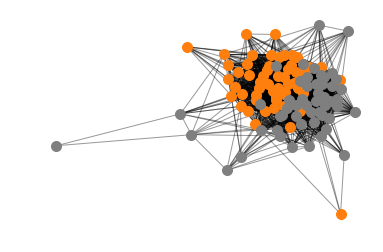

In [104]:
import networkx as nx
from networkx.drawing import spring_layout
from functools import reduce

# thresh = np.percentile(np.abs(layer_adj_matrix), 10)
# layer_adj_matrix[np.abs(layer_adj_matrix)<thresh] = 0.0

inv_adj_matrix = np.reciprocal(layer_adj_matrix)
# Truncate high values
thresh = np.percentile(inv_adj_matrix, 70)
print(thresh)
inv_adj_matrix[inv_adj_matrix>thresh] = 0.0
inv_adj_matrix[inv_adj_matrix<0] = 0.0

# layer_adj_matrix2 = layer_adj_matrix.copy()
# layer_adj_matrix2[layer_adj_matrix2<0] = 0.0
# thresh = np.percentile(layer_adj_matrix2, 50)
# layer_adj_matrix2[layer_adj_matrix2>thresh] = 0.0

G = nx.Graph(inv_adj_matrix)
# G = nx.Graph(layer_adj_matrix2)
# nx.drawing.nx_pylab.draw_spring(G, node_size=40, weight='weight')
layout = spring_layout(G, weight='weight')

# Plot each digit as a different color
labels = np.argmax(Y_test,axis=1)[repr_indices[max_vals!=0]]
for i in range(max(nums)+1):
    digit_set = [x[0] for x in np.argwhere(labels==i)]
    print(digit_set)
    # nodes
    nx.draw_networkx_nodes(G,layout,
                           nodelist=digit_set,
                           node_color='C{}'.format(i),
                           node_size=100)

# edges
nx.draw_networkx_edges(G,layout,width=1.0,alpha=0.4)
plt.axis('off')
plt.show()

In [105]:
from networkx.algorithms.community import girvan_newman
from networkx import edge_betweenness_centrality
def weighted_centrality(G):
    return max(edge_betweenness_centrality(G, weight='weight').items(), key=lambda x:x[1])[0]
communities = girvan_newman(G, weighted_centrality)

In [81]:
ebc = edge_betweenness_centrality(G, weight='weight')
# print(ebc)
print(max(ebc.items(), key=lambda x:x[1]))

((10, 62), 0.17817974647486112)


In [ ]:
for x in communities:
    print(x)
    for community in x:
        print([labels[i] for i in community])

({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105}, {19})
[1, 1, 7, 1, 7, 7, 1, 1, 1, 1, 1, 1, 1, 7, 7, 1, 1, 7, 1, 1, 7, 1, 7, 7, 1, 7, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7, 7, 1, 7, 1, 1, 1, 1, 7, 1, 7, 7, 7, 1, 1, 1, 1, 7, 7, 7, 7, 7, 1, 7, 1, 7, 1, 1, 1, 7, 7, 1, 7, 1, 1, 7, 7, 7, 7, 7, 1, 7, 1, 7, 7, 1, 1, 1, 7, 1, 1, 7, 7, 1, 1, 7, 1, 7, 7, 7, 1, 1, 7, 7, 7, 1, 7, 1, 7, 7]
[7]
({0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 66, 67,

({0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 63, 64, 65, 68, 69, 70, 71, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 97, 98, 99, 100, 101, 102, 103, 105}, {5}, {19}, {35}, {44}, {45}, {47}, {62}, {66}, {67}, {72}, {96}, {104})
[1, 1, 7, 1, 7, 1, 1, 1, 1, 1, 1, 1, 7, 7, 1, 1, 7, 1, 1, 7, 1, 7, 7, 1, 7, 1, 1, 1, 1, 1, 1, 7, 7, 7, 7, 1, 7, 1, 1, 1, 1, 7, 7, 1, 1, 1, 1, 7, 7, 7, 7, 7, 1, 7, 1, 7, 1, 1, 7, 7, 1, 1, 7, 7, 7, 7, 1, 7, 1, 7, 7, 1, 1, 1, 7, 1, 1, 7, 7, 1, 1, 7, 1, 7, 7, 7, 1, 7, 7, 7, 1, 7, 1, 7]
[7]
[7]
[7]
[7]
[1]
[7]
[1]
[7]
[1]
[7]
[1]
[7]
